# A demo of K-Means clustering on the handwritten digits data

Adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In this example we compare the various initialization strategies for K-means in terms of runtime and quality of the results.

As the ground truth is known here, we also apply different cluster quality metrics to judge the goodness of fit of the cluster labels to the ground truth.

In [1]:
using PyPlot    # ] (for Pkg REPL mode) then add PyPlot to install (or Pkg.add("PyPlot") for older Julia
using ScikitLearn, Random, Printf
using PyCall
using ScikitLearn.Utils: meshgrid

@sk_import cluster: KMeans
@sk_import datasets: load_digits
@sk_import decomposition: PCA
@pyimport sklearn.metrics as metrics
@pyimport sklearn.preprocessing as preprocessing

In [2]:
Random.seed!(42)

digits = load_digits()
data = preprocessing.scale(digits["data"])

n_samples, n_features = size(data)
n_digits = length(unique(digits["target"]))
labels = digits["target"]

sample_size = 300

@printf("n_digits: %d, \t n_samples %d, \t n_features %d\n", n_digits, n_samples, n_features)


println("____________________________________________________________________________")
@printf("% 9s", "init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette\n")

function bench_k_means(estimator, name, data)
    t0 = time()
    fit!(estimator, data)
    @printf("% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f\n",
            name, time()-t0, estimator.inertia_,
            metrics.homogeneity_score(labels, estimator.labels_),
            metrics.completeness_score(labels, estimator.labels_),
            metrics.v_measure_score(labels, estimator.labels_),
            metrics.adjusted_rand_score(labels, estimator.labels_),
            metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
            metrics.silhouette_score(data, estimator.labels_,
                                      metric="euclidean",
                                      sample_size=sample_size))
end

bench_k_means(KMeans(init="k-means++", n_clusters=n_digits, n_init=10),
              "k-means++", data)

bench_k_means(KMeans(init="random", n_clusters=n_digits, n_init=10),
              "random", data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = fit!(PCA(n_components=n_digits), data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              "PCA-based",
              data)
print("____________________________________________________________________________")

n_digits: 10, 	 n_samples 1797, 	 n_features 64
____________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   0.25s    69684   0.678   0.717   0.697   0.569   0.674    0.124
   random   0.21s    69672   0.683   0.722   0.702   0.574   0.680    0.140
PCA-based   0.03s    70804   0.671   0.698   0.684   0.561   0.668    0.122
____________________________________________________________________________

In [3]:
labels = KMeans

PyObject <class 'sklearn.cluster.k_means_.KMeans'>

In [4]:
fit!(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1), data).labels_

  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/cedric/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/cedric/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/cedric/.julia/v0.5/PyCall/sr

1797-element Array{Int32,1}:
 3
 2
 2
 9
 0
 9
 4
 1
 9
 9
 3
 6
 7
 ⋮
 1
 9
 9
 0
 2
 2
 0
 9
 3
 2
 9
 9

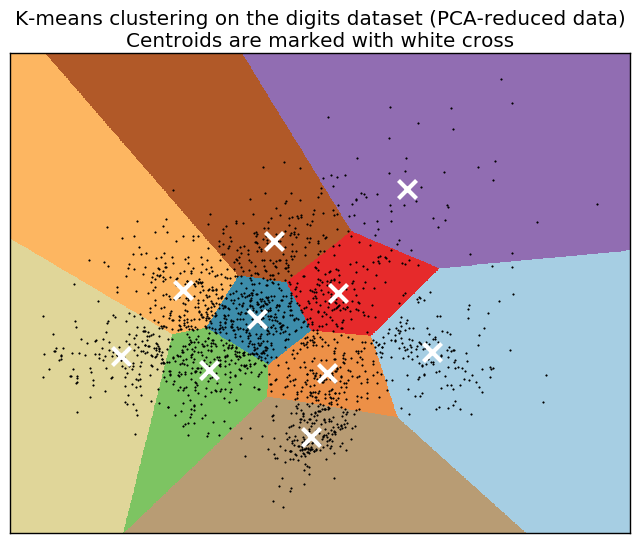

(Any[],Any[])

In [5]:
###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = fit_transform!(PCA(n_components=2), data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=10)
fit!(kmeans, reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = minimum(reduced_data[:, 1]) - 1, maximum(reduced_data[:, 1]) + 1
y_min, y_max = minimum(reduced_data[:, 2]) - 1, maximum(reduced_data[:, 2]) + 1
xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max);

# Obtain labels for each point in mesh. Use last trained model.
Z = predict(kmeans, hcat(xx[:], yy[:]))

# Put the result into a color plot
Z = reshape(Z, size(xx)...)

imshow(Z, interpolation="nearest",
        extent=(minimum(xx), maximum(xx), minimum(yy), maximum(yy)),
       cmap=PyPlot.cm[:Paired],
       aspect="auto", origin="lower")

plot(reduced_data[:, 1], reduced_data[:, 2], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
scatter(centroids[:, 1], centroids[:, 2],
        marker="x", s=169, linewidths=3,
        color="w", zorder=10)
title("K-means clustering on the digits dataset (PCA-reduced data)\n"*"Centroids are marked with white cross")
xlim(x_min, x_max)
ylim(y_min, y_max)
xticks(())
yticks(())